In [2]:
from source.MI import MI
from source.datalib import *
from source.gradient_ssim import MultiModalAlignmentMetric
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter, laplace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.functional import F
import torch.optim.lr_scheduler as lr_scheduler

wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

# Algorithm MI

In [128]:
class AffineTransform(nn.Module):
    def __init__(self,
                 scale_x_pred, scale_y_pred,
                 translation_x_pred, translation_y_pred,
                 angle_pred,
                 s_tol = 0, t_tol = 0, a_tol = 0,
                 device = 'cpu'):
        super().__init__()
        self.scalex = nn.Parameter(torch.tensor(scale_x_pred, dtype=torch.float, device=device))
        self.scaley = nn.Parameter(torch.tensor(scale_y_pred, dtype=torch.float, device=device))
        self.transX = nn.Parameter(torch.tensor(translation_x_pred, dtype=torch.float, device=device))
        self.transY = nn.Parameter(torch.tensor(translation_y_pred, dtype=torch.float, device=device))
        self.angle = nn.Parameter(torch.tensor(angle_pred, dtype=torch.float, device=device))
        self.device = device

        self.scale_x_bounds = (scale_x_pred - s_tol, scale_x_pred + s_tol)
        self.scale_y_bounds = (scale_y_pred - s_tol, scale_y_pred + s_tol)
        self.translation_x_bounds = (translation_x_pred - t_tol, translation_x_pred + t_tol)
        self.translation_y_bounds = (translation_y_pred - t_tol, translation_y_pred + t_tol)
        self.angle_bounds = (angle_pred - a_tol, angle_pred + a_tol)

    def get_theta(self):
        cos_angle = torch.cos(self.angle)
        sin_angle = torch.sin(self.angle)

        # Create rotation matrix (3x3)
        R = torch.stack([
            torch.stack([cos_angle, -sin_angle, torch.zeros(1, device=self.device).squeeze()]),
            torch.stack([sin_angle, cos_angle, torch.zeros(1, device=self.device).squeeze()]),
            torch.tensor([0., 0., 1.], device=self.device)
        ])

        # Create scaling matrix (3x3)
        S = torch.stack([
            torch.stack([self.scalex, torch.zeros(1, device=self.device).squeeze(), torch.zeros(1, device=self.device).squeeze()]),
            torch.stack([torch.zeros(1, device=self.device).squeeze(), self.scaley, torch.zeros(1, device=self.device).squeeze()]),
            torch.tensor([0., 0., 1.], device=self.device)
        ])

        # Create translation matrix (3x3)
        T = torch.stack([
            torch.stack([torch.ones(1, device=self.device).squeeze(), torch.zeros(1, device=self.device).squeeze(), self.transX]),
            torch.stack([torch.zeros(1, device=self.device).squeeze(), torch.ones(1, device=self.device).squeeze(), self.transY]),
            torch.tensor([0., 0., 1.], device=self.device)
        ])

        M = torch.matmul(torch.matmul(T, R), S)
        M_inv = torch.inverse(M)
        return M_inv[:2, :].unsqueeze(0)

    def forward(self, x, y_size):
        self.scalex.data = torch.clamp(self.scalex.data, self.scale_x_bounds[0], self.scale_x_bounds[1])
        self.scaley.data = torch.clamp(self.scaley.data, self.scale_y_bounds[0], self.scale_y_bounds[1])
        self.transX.data = torch.clamp(self.transX.data, self.translation_x_bounds[0], self.translation_x_bounds[1])
        self.transY.data = torch.clamp(self.transY.data, self.translation_y_bounds[0], self.translation_y_bounds[1])
        self.angle.data = torch.clamp(self.angle.data, self.angle_bounds[0], self.angle_bounds[1])

        theta = self.get_theta()
        grid = F.affine_grid(theta, y_size, align_corners=False)
        return F.grid_sample(x, grid, align_corners=False)

def optimize_affine_transform_pytorch(to_transform, 
                                    target_image,
                                    edge_align = False,
                                    device = 'cpu', 
                                    lr = 1e-4, 
                                    mom = 0.8, 
                                    num_iters = 400, 
                                    scale_x_pred = 1, scale_y_pred = 1, s_tol = 0.2, 
                                    translation_x_pred = 0, translation_y_pred = 0, t_tol = 0.3, 
                                    angle_pred = 0, a_tol = np.pi/6,
                                    ):
    
    mutual_info = MI(dimension = 2, num_bins = 64, kernel_sigma = 1).to(device)

    best_params = None
    best_loss = float('-inf')

    # Convert images to torch tensors and move to specified device
    
    if edge_align:
        to_transform = (np.gradient(to_transform)[0]**2 + np.gradient(to_transform)[1]**2)
        target_image = (np.gradient(target_image)[0]**2 + np.gradient(target_image)[1]**2)

    to_transform = torch.tensor(to_transform).unsqueeze(0).unsqueeze(0).float().to(device)
    target_image = torch.tensor(target_image).unsqueeze(0).unsqueeze(0).float().to(device)

    model = AffineTransform(scale_x_pred = scale_x_pred, scale_y_pred = scale_y_pred, s_tol = s_tol,
                            translation_x_pred = translation_x_pred, translation_y_pred = translation_y_pred, t_tol = t_tol,
                            angle_pred = angle_pred, a_tol = a_tol,
                            device = device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = mom, maximize = True)
    # optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, T_mult = 2, eta_min = 1e-4, last_epoch = -1)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 0.85, end_factor = 1, total_iters = num_iters)

    for epoch in range(num_iters):
        optimizer.zero_grad()
        transformed_image = model(to_transform, target_image.size())
        loss = mutual_info.mi(transformed_image, target_image, mask = transformed_image!=0)
        
        print(f'Epoch: {epoch}/{num_iters}, Loss: {loss.item():.3f}, Best: {best_loss}', end='\r')
        if loss.item() > best_loss:
            best_loss = loss.item()
            best_params = {
                'rot_angle': model.angle.item(),
                'translate': [model.transX.item(), model.transY.item()],
                'scale_x': model.scalex.item(),
                'scale_y': model.scaley.item(),                    
            }
        loss.backward()
        optimizer.step()
        scheduler.step()

    return best_params, model

# 1. Load the two Modalities

## 1.1 LIBS

In [4]:
file_libs_metadata = r'E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines
getting map dimensions


In [5]:
modality1 = spectrum[::-1, :, wavelength_to_index(266.106, wavelengths)].T

## 1.2 Optical Image

In [6]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_image = main_dir + sample_dir + r"Histology//"

def read_image(folder, index = 0):
    files = [folder + '//' + f for f in os.listdir(folder) if f.endswith('jpg')]
    return io.imread(files[index])

sample_image = read_image(dir_image)

In [7]:
modality2 = sample_image[:, 285:1420, 0]

## 1.3 Check Downsample 

C:\Users\tomas\AppData\Local\Temp\ipykernel_18924\1499266249.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize = (10, 4))


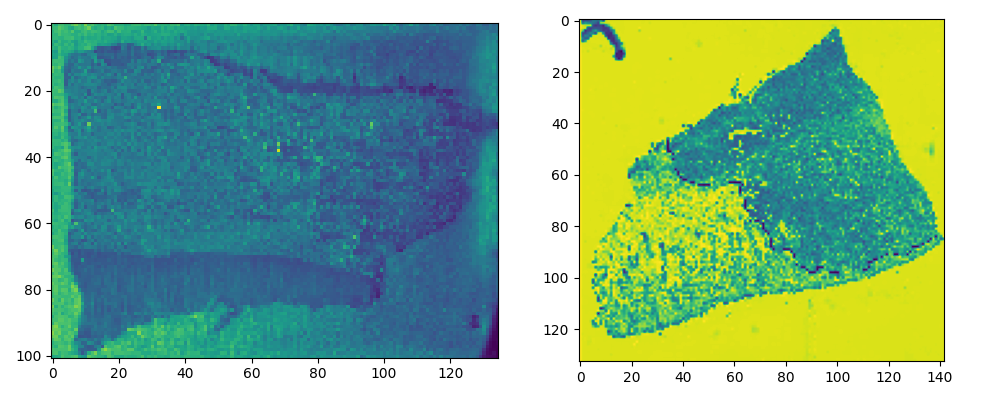

In [42]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

step_mod1 = 4
ax = axs[0]
ax.imshow(gaussian_filter(modality1[::step_mod1, ::step_mod1], sigma = 0))

step_mod2 = 8
ax = axs[1]
ax.imshow(gaussian_filter(modality2[::step_mod2, ::step_mod2]/np.max(modality2[::step_mod2, ::step_mod2]), sigma = 0))

fig.tight_layout()

## 1.4 Process both images for Alignment

In [44]:
mod1 = gaussian_filter(modality1[::step_mod1, ::step_mod1], sigma = 0) #/np.max(modality1[::step_mod1, ::step_mod1]), sigma = 1)
# mod1 += np.random.random(mod1.shape)*1e-1
mod1_grad = (np.gradient(mod1)[0]**2 + np.gradient(mod1)[1]**2)


mod2 = gaussian_filter(modality2[::step_mod2, ::step_mod2], sigma  = 0)  #/np.max(modality2[::step_mod2, ::step_mod2]), sigma = 1.5)
mod2_grad = (np.gradient(mod2)[0]**2 + np.gradient(mod2)[1]**2)

# 2. Alignment

## 2.1 Initial Manual Adjustment

In [12]:
from matplotlib.widgets import Slider

def visualize_affine_transform_with_sliders(mod1, mod2):
    """
    Visualizes the affine transformation of mod1 to align with mod2 using sliders to control
    scale, translation, and rotation.

    Parameters:
    mod1: numpy.ndarray
        The image to be transformed (first image).
    mod2: numpy.ndarray
        The target image (second image) to overlay the transformed mod1 on.
    """
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.4)

    init_scale_x = 1.0
    init_scale_y = 1.0
    init_translation_x = 0.0
    init_translation_y = 0.0
    init_angle = 0.0

    affine_transform = AffineTransform(init_scale_x, init_scale_y, init_translation_x, init_translation_y, init_angle)
    to_transform = torch.tensor(mod1).unsqueeze(0).unsqueeze(0).float()
    target_image = torch.tensor(mod2).unsqueeze(0).unsqueeze(0).float()

    transformed_img1_tensor = affine_transform(to_transform, target_image.size())
    transformed_img1 = transformed_img1_tensor.squeeze(0).squeeze(0).detach().numpy()

    img_plot = ax.imshow(mod2, cmap='gray', alpha=0.5)
    img_plot_transformed = ax.imshow(transformed_img1, cmap='jet', alpha=0.5)

    ax_scale_x = plt.axes([0.25, 0.25, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    ax_scale_y = plt.axes([0.25, 0.2, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    ax_translation_x = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    ax_translation_y = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
    ax_angle = plt.axes([0.25, 0.05, 0.65, 0.03], facecolor='lightgoldenrodyellow')

    slider_scale_x = Slider(ax_scale_x, 'Scale X', 0.5, 2.0, valinit=init_scale_x)
    slider_scale_y = Slider(ax_scale_y, 'Scale Y', 0.5, 2.0, valinit=init_scale_y)
    slider_translation_x = Slider(ax_translation_x, 'Trans X', -1, 1, valinit=init_translation_x)
    slider_translation_y = Slider(ax_translation_y, 'Trans Y', -1, 1, valinit=init_translation_y)
    slider_angle = Slider(ax_angle, 'Angle', 0, 2*np.pi, valinit = init_angle)

    def update(val):
        scale_x = slider_scale_x.val
        scale_y = slider_scale_y.val
        translation_x = slider_translation_x.val
        translation_y = slider_translation_y.val
        angle = slider_angle.val

        affine_transform = AffineTransform(scale_x, scale_y, translation_x, translation_y, angle)
        transformed_img1_tensor = affine_transform(to_transform, target_image.size())
        transformed_img1 = transformed_img1_tensor.squeeze(0).squeeze(0).detach().numpy()

        img_plot_transformed.set_data(transformed_img1)
        fig.canvas.draw_idle()

    slider_scale_x.on_changed(update)
    slider_scale_y.on_changed(update)
    slider_translation_x.on_changed(update)
    slider_translation_y.on_changed(update)
    slider_angle.on_changed(update)

    plt.show()

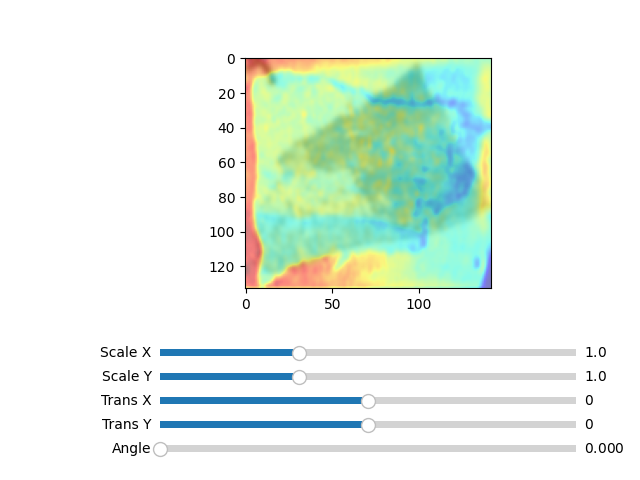

In [13]:
visualize_affine_transform_with_sliders(mod1, mod2)

## 2.2 Fine Tune by maximizing mutual information

In [129]:
device = 'cuda' #'cuda' if torch.cuda.is_available() else 'cpu'
# rot_angle_range = np.linspace(0, 3*np.pi/2, 4)

best_params, mode = optimize_affine_transform_pytorch(mod1, 
                                                    mod2, 
                                                    edge_align = True,
                                                    device = device, 
                                                    lr = 1.3e-4, 
                                                    mom = 0.96, 
                                                    num_iters = 400, 
                                                    scale_x_pred = 1.016, scale_y_pred = 0.833, s_tol = 0.1,
                                                    translation_x_pred = -0.103, translation_y_pred = 0.098, t_tol = 0.1,
                                                    angle_pred = 2.731, a_tol = 0.2)
print(best_params)

{'rot_angle': 2.7149229049682617, 'translate': [-0.10260751098394394, 0.10445588082075119], 'scale_x': 1.0012450218200684, 'scale_y': 0.7547699809074402}


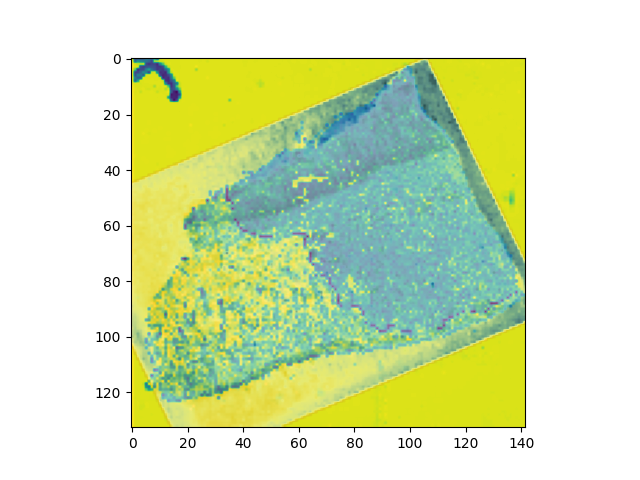

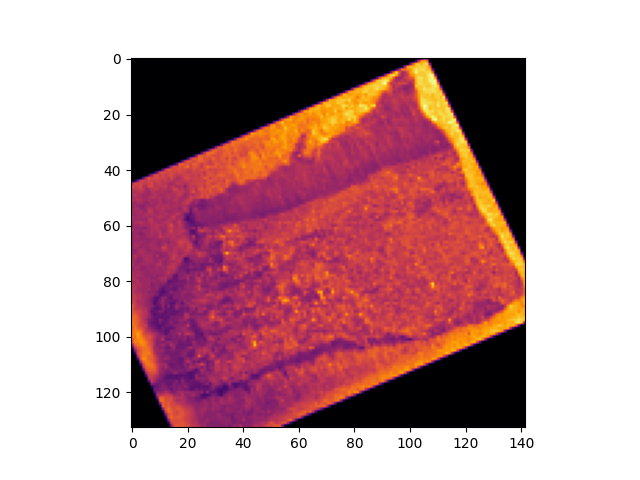

In [130]:
scalex = best_params['scale_x']
scaley = best_params['scale_y']

angle = best_params['rot_angle']
tx = best_params['translate'][0]
ty = best_params['translate'][1]

affine_final = AffineTransform(scalex, scaley, tx, ty, angle)
transformed_image = affine_final(torch.tensor(mod1).float().unsqueeze(0).unsqueeze(0), 
                                 torch.tensor(mod2).float().unsqueeze(0).unsqueeze(0).size()).squeeze(0).squeeze(0).detach().numpy()

from matplotlib.colors import ListedColormap

cmap = plt.cm.RdBu
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, .8, cmap.N)
my_cmap = ListedColormap(my_cmap)

plt.figure()
plt.imshow(mod2)
plt.imshow(transformed_image, cmap = my_cmap)

plt.figure()
plt.imshow(transformed_image, cmap = 'inferno', alpha = 1)